In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


In [2]:
%matplotlib inline

# Calibration

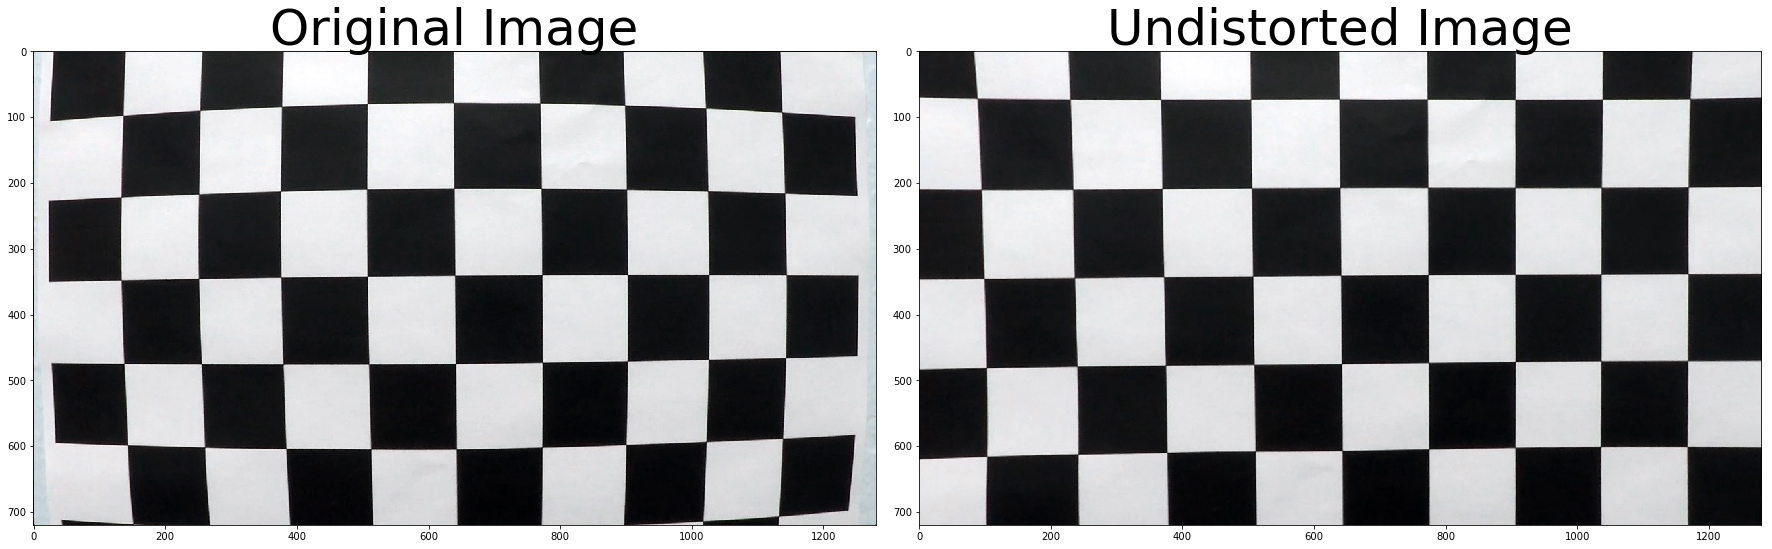

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objpoints = [] # 3d rw
imgpoints = [] # 2d img

# Init corner grid
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # I hate having to type all this

for file in images:
    img = cv2.imread(file)

    #Grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Get corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    #Append corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# 1, 2, 3, Calibrate!
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


#Generating a before/after test image
test = cv2.imread('camera_cal/calibration1.jpg')
test_ud = cv2.undistort(test,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_ud)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Pipeline

## 1. Distortion Correction

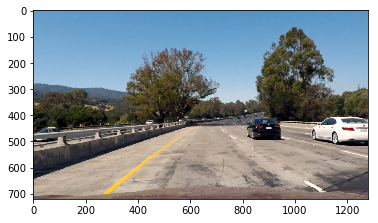

In [5]:
test1 = cv2.undistort(mpimg.imread('test_images/test1.jpg'), mtx, dist, None, mtx)
plt.imshow(test1)

In [6]:
mpimg.imsave('output_images/test1_undistorted.png',test1)

## 2. Binary Image

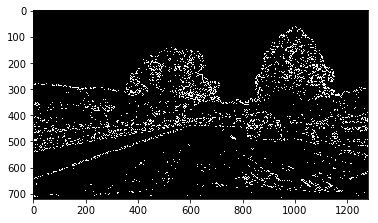

In [7]:
#Some handy Sobel functions if I need them

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
# Applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.

   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel1 = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    if orient == 'y':
        sobel1 = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel1)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test1, orient='x', sobel_kernel=15, thresh=(20, 100))
grady = abs_sobel_thresh(test1, orient='y', sobel_kernel=15, thresh=(20, 100))
mag_binary = mag_thresh(test1, sobel_kernel=15, mag_thresh=(30, 100))
dir_binary = dir_threshold(test1, sobel_kernel=ksize, thresh=(.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap='gray')

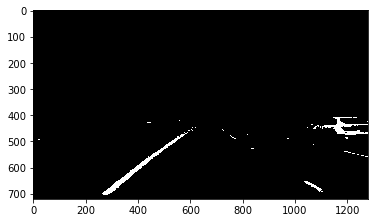

In [8]:
hls = cv2.cvtColor(test1, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

binary = np.zeros_like(S)
binary[((S > 90) & (S <= 255) & ((H > 15) & (H <= 100))) & ((L>90)&(L<=255))] = 1
plt.imshow(binary, cmap='gray')

In [9]:
mpimg.imsave('output_images/test1_binary.png',binary,cmap='gray')

## 3. Perspective Transform

In [12]:
img_size = test_ud.shape[0:2]
img_size = img_size[::-1]

# This looks like a reasonable transform
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Get the transform matrix
M = cv2.getPerspectiveTransform(src,dst)

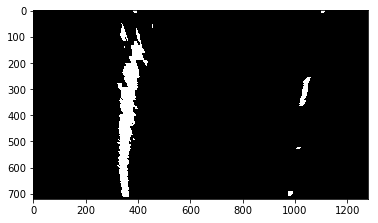

In [13]:
# Transform!
warped = cv2.warpPerspective(binary,M,img_size,flags=cv2.INTER_LINEAR)

plt.imshow(warped, cmap='gray')

In [14]:
mpimg.imsave('output_images/test1_warped.png',warped,cmap='gray')

In [15]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 200 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset,0))    # I took out -margin here because the window was sliding over too far in the event of no discovery in multiple levels
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

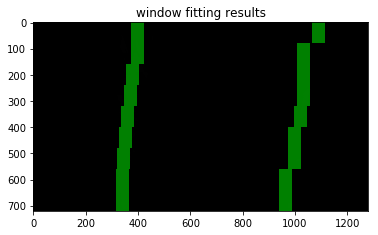

In [16]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [17]:
mpimg.imsave('output_images/test1_output.png',output)

## 4. Polynomial Fit

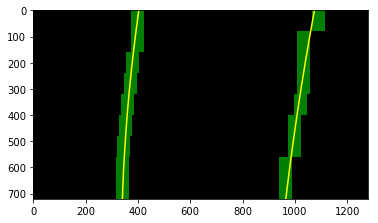

In [18]:
leftx = np.array(window_centroids)[:,0]
rightx = np.array(window_centroids)[:,1]

lefty = righty = np.linspace(warped.shape[0],0,int(warped.shape[0]/window_height))



# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(output)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
f.tight_layout()
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/test1_poly.png')

## 5. Curvature

In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature  : note y_eval has been replaced by np.max(lefty)
left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Calculate the offset by taking difference of left and right widths
drift = xm_per_pix*(rightx[0] + leftx[0] - img_size[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
print('drift right: ', drift,'m')
# Example values: 632.1 m    626.2 m

2194.94847946 m 3605.74113663 m
drift right:  0.153285714286 m


## 6. Plotted Result

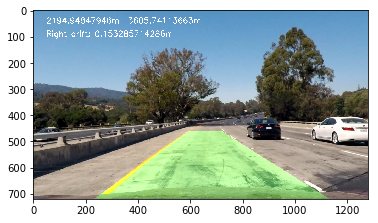

In [30]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Get inverse transform
Minv = cv2.getPerspectiveTransform(dst,src)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 
# Combine the result with the original image
result = cv2.addWeighted(test1, 1, newwarp, 0.3, 0)
result = cv2.putText(result, str(left_curverad)+'m  '+str(right_curverad)+'m',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
result = cv2.putText(result, 'Right drift: '+str(drift)+'m',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)


plt.imshow(result)

plt.imsave('output_images/test1_final.png',result)

##### Now we're going to put it all together.

## Define a full per-image function

In [67]:
pts_old = None

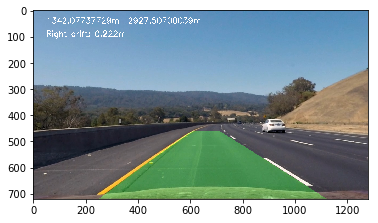

In [68]:
def paintFrame(frame):
    global pts_old
    fixed = cv2.undistort(frame, mtx, dist, None, mtx)


    hls = cv2.cvtColor(fixed, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[((S > 90) & (S <= 255) & ((H > 15) & (H <= 100))) & ((L>90)&(L<=255))] = 1



    warped = cv2.warpPerspective(binary,M,img_size, None, flags=cv2.INTER_LINEAR)




    window_centroids = find_window_centroids(warped, window_width, window_height, margin)




    leftx = np.array(window_centroids)[:,0]
    rightx = np.array(window_centroids)[:,1]

    lefty = righty = np.linspace(warped.shape[0],0,int(warped.shape[0]/window_height))

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature  : note y_eval has been replaced by np.max(lefty)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the offset by taking difference of left and right widths
    drift = xm_per_pix*(rightx[0] + leftx[0] - img_size[0])



    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    

    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
### Addition to fix bad polys
    if (pts_old == None):
        pts_old = color_warp[:,:,1]
    #print(pts_old.shape)
    #print(color_warp.shape)
    a = pts_old
    b = color_warp[:,:,1]
    #print(pts.shape)
    #print(pts_old.shape)
    ret = cv2.matchShapes(a,b,1,0.0)
    #print(pts_old)
    if (ret>0.045):
        pts_old = color_warp[:,:,1]
    else:
        color_warp[:,:,1] = pts_old # overwrite the current pts set with our history. keep pts_old.
###

    # Get inverse transform
    Minv = cv2.getPerspectiveTransform(dst,src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size, flags=cv2.INTER_LINEAR) 

    # Combine the result with the original image
    result = cv2.addWeighted(fixed, 1, newwarp, 0.3, 0)
    
    result = cv2.putText(result, str(left_curverad)+'m  '+str(right_curverad)+'m',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    result = cv2.putText(result, 'Right drift: '+str(drift)+'m',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)


    
    return result  #, drift, (left_curverad,right_curverad)

frame = mpimg.imread('test_images/test3.jpg')
result = paintFrame(frame) #, d, (left,right) = paintFrame(frame)
plt.imshow(result)
#print(left, 'm', right, 'm')
#print('drift right: ', d,'m')

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputfile = 'result_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
resultclip = clip1.fl_image(paintFrame) #NOTE: this function expects color images!!
resultclip.write_videofile(outputfile, audio=False)

[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████▉| 1260/1261 [09:24<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 



In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="./{0}">
</video>
""".format(outputfile))

In [70]:
output2 = 'chresult.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
resultclip2 = clip2.fl_image(paintFrame) #NOTE: this function expects color images!!
resultclip2.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video chresult.mp4
[MoviePy] Writing video chresult.mp4


100%|██████████| 485/485 [03:52<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: chresult.mp4 



In [71]:
output3 = 'hchresult.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
resultclip3 = clip3.fl_image(paintFrame) #NOTE: this function expects color images!!
resultclip3.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video hchresult.mp4
[MoviePy] Writing video hchresult.mp4


100%|█████████▉| 1199/1200 [10:30<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: hchresult.mp4 

